# Preparing ENV

In [4]:
# %pip install --upgrade pip
# %pip install pandas numpy
# %pip install scikit-learn scipy
# %pip install odfpy
# %pip install kneed
# %pip install matplotlib seaborn

## Imports

In [5]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from kneed import KneeLocator

import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
## baseline data
data_source = "202211_en.ods"
baseline_name = data_source.split(".")[0].split("_")[0]

In [7]:
sample_data = pd.read_excel(f"data/{data_source}", engine="odf", index_col=None)
sample_data.rename(columns={"            StationDate": "StationDate"}, inplace=True)
sample_data.columns

sample_data.index = range(1, sample_data.shape[0]+1)
# day_lines = sample_data.plot.line(legend=None)

In [8]:
## create day of week
sample_data["day_of_week"] = sample_data['StationDate'].dt.day_name()
day_of_week_mark = sample_data[["StationDate", "day_of_week"]]

sample_data.head()

,StationDate,Songshan Airport,Zhongshan Junior High School,Nanjing Fuxing,Zhongxiao Fuxing,Daan,Technology Building,Liuzhangli,Linguang,Xinhai,...,Jingping,Zhonghe,Qiaohe,Zhongyuan,Banxin,Banqiao(Circular Line),Xingpu Minsheng,Xingfu,New Taipei Industrial Park,day_of_week
1,2022-11-01,3614,13390,40071,35788,24151,13755,10520,3716,3094,...,4233,4729,2488,3736,3165,7348,2471,3922,5282,Tuesday
2,2022-11-02,3572,13384,40111,36458,23851,13528,10602,3754,3008,...,4021,4610,2434,3591,3044,7335,2401,3872,4984,Wednesday
3,2022-11-03,3733,13150,39857,37400,23797,13512,10433,3605,3113,...,3945,4638,2459,3611,2952,7755,2364,3841,4968,Thursday
4,2022-11-04,4349,14062,42148,44432,25270,13868,11118,3901,3162,...,4216,4819,2569,3607,3096,10184,2539,4268,5285,Friday
5,2022-11-05,2770,8362,22229,41220,14931,10190,7567,3292,2223,...,2867,4207,1221,1319,1946,8153,1876,3235,3376,Saturday


## Min-Max Normalize

In [9]:
day_data = sample_data.drop(columns=["StationDate", "day_of_week"])

scaler = MinMaxScaler()
scaler.fit(day_data)

scaled_day_data = scaler.fit_transform(day_data)
scaled_day_data = pd.DataFrame(scaled_day_data, columns=day_data.columns)
scaled_day_data = scaled_day_data.transpose()


day_data = day_data.transpose()
scaled_day_data.columns = day_data.columns

## Find k of groups(by day) for KMeans (result: 3 groups)

3


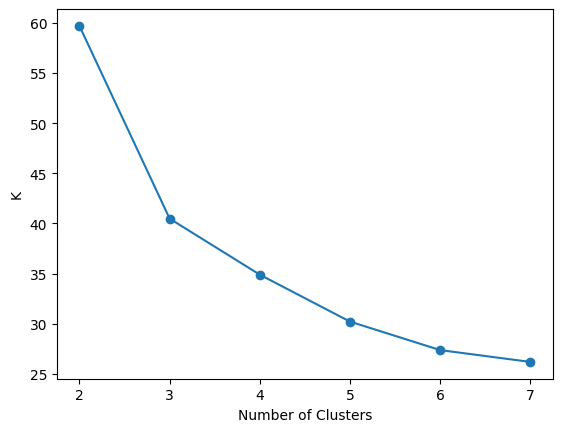

In [10]:
def find_k(df, upperbound=8):
    ks = []
    for k in range(2, upperbound):
        model = KMeans(n_clusters=k, random_state=7, n_init="auto").fit(df)
        ks.append(model.inertia_)

    ## Plotting the inertia of the models    
    k_values = range(2, upperbound)
    plt.plot(k_values, ks, "o-")
    plt.xlabel("Number of Clusters")
    plt.ylabel("K")

    ## Using elbow methods
    kn = KneeLocator(k_values, ks, curve="convex", direction="decreasing")
    return kn.knee

k = find_k(scaled_day_data)
print(k)

In [11]:
##
def k_means_df(df, num_clusters):
    kmeans = KMeans(n_clusters=num_clusters, random_state=7, n_init="auto")
    kmeans.fit(df)
    df['cluster'] = kmeans.labels_
    return df

km_day = k_means_df(scaled_day_data, k)
km_day.head()

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,cluster
Songshan Airport,0.533543,0.514633,0.587123,0.864475,0.153534,0.045925,0.615489,0.498424,0.546150,0.667267,...,0.622692,0.646105,0.760468,1.000000,0.129221,0.000000,0.665016,0.646556,0.612337,2
Zhongshan Junior High School,0.866658,0.865906,0.836553,0.950953,0.235951,0.003011,0.777847,0.871425,0.876317,0.878324,...,0.854240,0.930758,0.943552,1.000000,0.182639,0.000000,0.775088,0.858254,0.905294,1
Nanjing Fuxing,0.817270,0.818644,0.809920,0.888610,0.204438,0.000000,0.737412,0.819159,0.825410,0.828467,...,0.833929,0.882702,0.921962,1.000000,0.186062,0.035275,0.764306,0.830013,0.863983,1
Zhongxiao Fuxing,0.211562,0.234133,0.265867,0.502762,0.394556,0.071756,0.193269,0.242690,0.315052,0.935959,...,0.241881,0.256502,0.307910,0.528938,0.268158,0.000000,0.175785,0.225408,0.292717,0
Daan,0.849878,0.830590,0.827118,0.921821,0.257104,0.000000,0.788415,0.841070,0.873666,0.866465,...,0.840298,0.914106,0.932107,1.000000,0.236852,0.051948,0.804616,0.866658,0.887875,1


In [12]:
## Group counts
byday_cluster = km_day[["cluster"]]
byday_cluster.reset_index(inplace=True)
byday_cluster.columns = ["StationCount", "cluster"]
byday_cluster.groupby("cluster").agg("count")

,StationCount
cluster,
0,20
1,66
2,33


## Inspecting groups

In [13]:
group0 = km_day.loc[km_day["cluster"] == 0]
group1 = km_day.loc[km_day["cluster"] == 1]
group2 = km_day.loc[km_day["cluster"] == 2]

In [14]:
group0_ = group0.drop(columns="cluster").transpose()
group0_["mean"] = group0_.mean(axis=1)

group1_ = group1.drop(columns="cluster").transpose()
group1_["mean"] = group1_.mean(axis=1)

group2_ = group2.drop(columns="cluster").transpose()
group2_["mean"] = group2_.mean(axis=1)

In [15]:
group0_.transpose().to_csv("results/group0_" + baseline_name + ".csv")
group1_.transpose().to_csv("results/group1_" + baseline_name + ".csv")
group2_.transpose().to_csv("results/group2_" + baseline_name + ".csv")

In [16]:
'''Only for testing

df = group0_

sunday_mark = day_of_week_mark.index[day_of_week_mark['day_of_week"] == "Sunday"].tolist()

plt.figure(figsize=(15, 8))
for col in df.columns:
    if not col == "mean":
        plt.plot(range(1, df.shape[0]+1), df[col], color="#d9d9d9")
    else:
        plt.plot(range(1, df.shape[0]+1), df[col], color="blue", label="mean")

#plot week boundary
for marker in sunday_mark:
    plt.axvline(x = marker, color = "gray', linestyle='--',linewidth=1)

#plot start and end boundary
plt.axvline(x = 1, color = 'k', linestyle='--',linewidth=1)
plt.axvline(x = df.shape[0], color = 'k', linestyle='--',linewidth=1)

plt.legend()
plt.show()

'''


'Only for testing\n\ndf = group0_\n\nsunday_mark = day_of_week_mark.index[day_of_week_mark[\'day_of_week"] == "Sunday"].tolist()\n\nplt.figure(figsize=(15, 8))\nfor col in df.columns:\n    if not col == "mean":\n        plt.plot(range(1, df.shape[0]+1), df[col], color="#d9d9d9")\n    else:\n        plt.plot(range(1, df.shape[0]+1), df[col], color="blue", label="mean")\n\n#plot week boundary\nfor marker in sunday_mark:\n    plt.axvline(x = marker, color = "gray\', linestyle=\'--\',linewidth=1)\n\n#plot start and end boundary\nplt.axvline(x = 1, color = \'k\', linestyle=\'--\',linewidth=1)\nplt.axvline(x = df.shape[0], color = \'k\', linestyle=\'--\',linewidth=1)\n\nplt.legend()\nplt.show()\n\n'

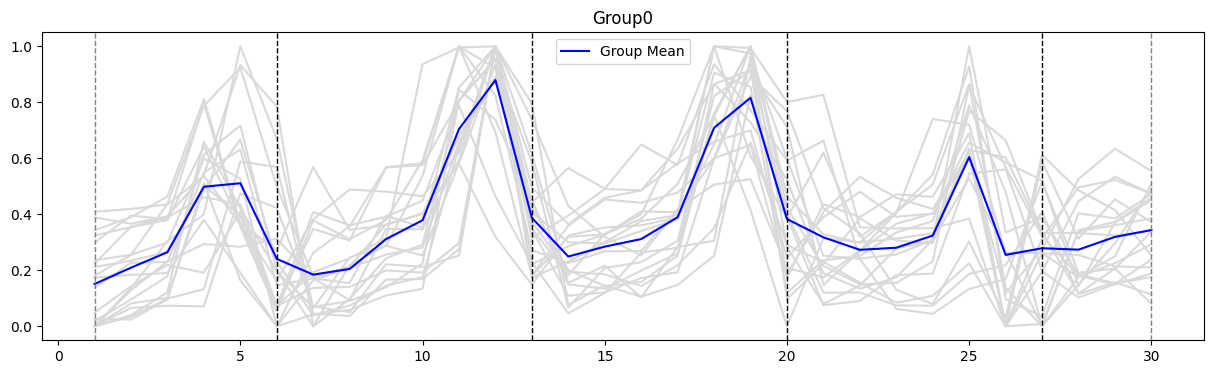

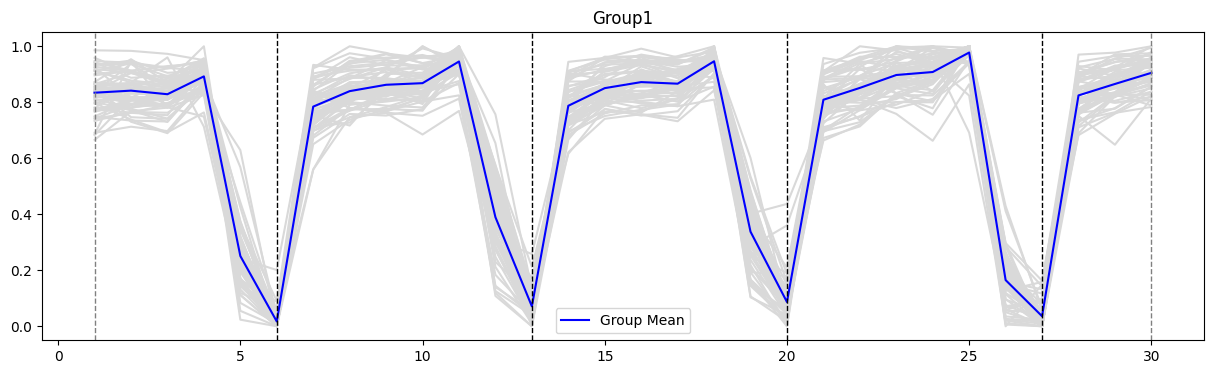

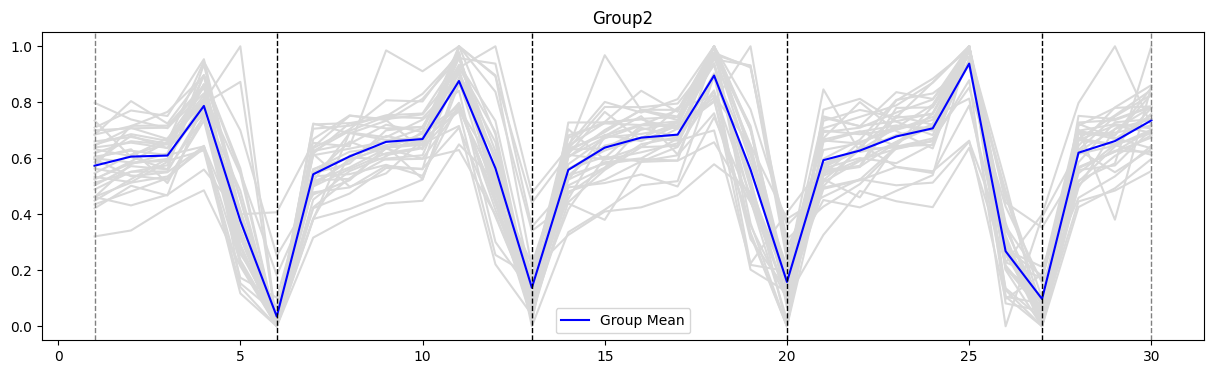

In [17]:
def plot_group_lines(df, day_of_week_mark, title=None):
    sunday_mark = day_of_week_mark.index[day_of_week_mark["day_of_week"] == "Sunday"].tolist()

    plt.figure(figsize=(15, 4))
    for col in df.columns:
        if not col == "mean":
            plt.plot(range(1, df.shape[0]+1), df[col], color="#d9d9d9")
        else:
            plt.plot(range(1, df.shape[0]+1), df[col], color="blue", label="Group Mean")

    #plot week boundary
    for marker in sunday_mark:
        plt.axvline(x = marker, color="k", linestyle="--", linewidth=1)

    #plot start and end boundary
    plt.axvline(x = 1, color="gray", linestyle="--",linewidth=1)
    plt.axvline(x = df.shape[0], color="gray", linestyle="--", linewidth=1)

    if title is not None:
        plt.title(title)
    plt.legend()
    plt.show()

plot_group_lines(group0_, day_of_week_mark, "Group0")
plot_group_lines(group1_, day_of_week_mark, "Group1")
plot_group_lines(group2_, day_of_week_mark, "Group2")

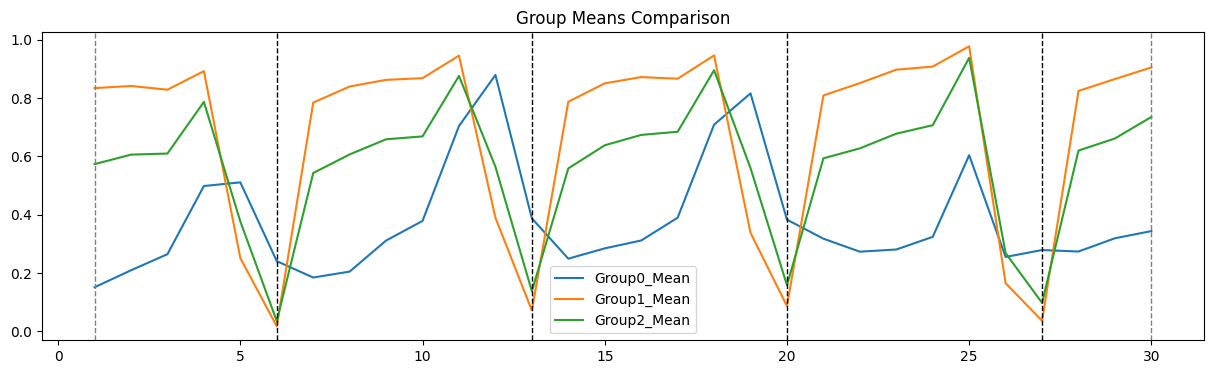

In [18]:
groups_means = pd.concat([group0_[["mean"]], group1_[["mean"]], group2_[["mean"]]], axis=1)
groups_means.columns = ["Group0_Mean", "Group1_Mean", "Group2_Mean"]
# groups_means_lines = groups_means.plot.line()


plt.figure(figsize=(15, 4))
for col in groups_means.columns:
    plt.plot(range(1, groups_means.shape[0]+1), groups_means[col], label=col)
#plot week boundary
sunday_mark = day_of_week_mark.index[day_of_week_mark['day_of_week'] == "Sunday"].tolist()
for marker in sunday_mark:
    plt.axvline(x = marker, color="k", linestyle='--', linewidth=1)

#plot start and end boundary
plt.axvline(x = 1, color="gray", linestyle='--',linewidth=1)
plt.axvline(x = groups_means.shape[0], color="gray", linestyle='--', linewidth=1)

plt.title("Group Means Comparison")
plt.legend()
plt.show()

groups_means.to_csv("results/group_means_" + baseline_name + ".csv")


## Group0 inspection

In [19]:
## target to comapre
# data_source_ = "201811_en.ods"
# data_source_ = "201911_en.ods"
# data_source_ = "202005_en.ods"
# data_source_ = "202006_en.ods"
data_source_ = "202205_en.ods"

target_name = data_source_.split(".")[0].split("_")[0]
before_pandemic = pd.read_excel(f"data/{data_source_}", engine="odf", index_col=None)
before_pandemic.rename(columns={"            StationDate": "StationDate"}, inplace=True)
before_pandemic.columns

before_pandemic.index = range(1, before_pandemic.shape[0]+1)

In [20]:
before_pandemic["day_of_week"] = before_pandemic["StationDate"].dt.day_name()

In [40]:
## data from some station were lost, collecting intersection
inspect_station_ = group0.index.tolist()
inspect_station = list(set(before_pandemic.columns).intersection(set(inspect_station_)))

pd.DataFrame(inspect_station, columns=["group0_station"]).to_csv("group0_station.csv")


In [22]:
inspection_before_pandemic_ = before_pandemic[inspect_station]
inspection_after_pandemic_ = sample_data[inspect_station]

inspection_after_pandemic_.to_csv(f"results/inspection_after_pandemic_origin_{target_name}-{baseline_name}.csv")
inspection_before_pandemic_.to_csv(f"results/inspection_before_pandemic_origin_{target_name}-{baseline_name}.csv")

In [23]:
scaler = MinMaxScaler()
scaler.fit(inspection_after_pandemic_)

inspection_after_pandemic = pd.DataFrame(scaler.fit_transform(inspection_after_pandemic_), columns=inspection_after_pandemic_.columns)
inspection_before_pandemic = pd.DataFrame(scaler.fit_transform(inspection_before_pandemic_), columns=inspection_before_pandemic_.columns)

inspection_after_pandemic.index = range(1, inspection_after_pandemic.shape[0]+1)
inspection_before_pandemic.index = range(1, inspection_before_pandemic.shape[0]+1)

## collecting scale size
cbar_scaler = [min(min(inspection_before_pandemic.min()), min(inspection_after_pandemic.min())), max(max(inspection_before_pandemic.max()), max(inspection_after_pandemic.max()))]

In [24]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True)
sns.heatmap(inspection_before_pandemic.transpose(), ax=ax1, cmap="Blues", vmin=cbar_scaler[0], vmax=cbar_scaler[1])
sns.heatmap(inspection_after_pandemic.transpose(), ax=ax2, cmap="Blues", vmin=cbar_scaler[0], vmax=cbar_scaler[1])
ax1.set_title(target_name)
ax2.set_title(baseline_name)
# plt.show()

plt.savefig(f"img/{target_name}-{baseline_name}_heatmap_compare.png", bbox_inches="tight", pad_inches=0.1)
plt.close()

### groupby day of week to compare

In [25]:
inspect_station.append("day_of_week")
inspection_before_pandemic_ = before_pandemic[inspect_station]
inspection_after_pandemic_ = sample_data[inspect_station]

In [26]:
day_of_week_before = inspection_before_pandemic_.groupby("day_of_week").agg("mean")
day_of_week_after = inspection_after_pandemic_.groupby("day_of_week").agg("mean")

day_of_week_before.to_csv(f"results/day_of_week_before_{target_name}-{baseline_name}.csv")
day_of_week_after.to_csv(f"results/day_of_week_after_{target_name}-{baseline_name}.csv")

In [27]:
day_of_week_before = day_of_week_before.reindex(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
day_of_week_after = day_of_week_after.reindex(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])

In [28]:
scaler = MinMaxScaler()
scaler.fit(day_of_week_after)
scaled_day_of_week_after = pd.DataFrame(scaler.transform(day_of_week_after), columns=day_of_week_after.columns)
scaled_day_of_week_before = pd.DataFrame(scaler.transform(day_of_week_before), columns=day_of_week_before.columns)

cbar_scaler = [min(min(scaled_day_of_week_before.min()), min(scaled_day_of_week_after.min())), max(max(scaled_day_of_week_before.max()), max(scaled_day_of_week_after.max()))]

In [29]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
sns.heatmap(scaled_day_of_week_before.transpose(), ax=ax1, cmap="Blues", vmin=cbar_scaler[0], vmax=cbar_scaler[1])
sns.heatmap(scaled_day_of_week_after.transpose(), ax=ax2, cmap="Blues", vmin=cbar_scaler[0], vmax=cbar_scaler[1])
ax1.set_title(target_name)
ax2.set_title(baseline_name)
ax2.set_xticklabels(["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"])
# plt.show()

plt.savefig(f"img/{target_name}-{baseline_name}_heatmap_weekday_compare.png", bbox_inches="tight", pad_inches=0.1)
plt.close()

some backups

In [30]:
# k_group0 = find_k(group0.drop(columns="cluster"), 15)

# km_group0 = k_means_df(group0.drop(columns="cluster"), k_group0)


In [31]:
# group0_group_count = km_group0[["cluster"]]
# group0_group_count.reset_index(inplace=True)
# group0_group_count.columns = ["Station", "cluster"]
# group0_group_count.groupby("cluster").agg("count")

In [32]:
# print(km_group0[km_group0["cluster"] == 3])
# Zhongxiao_Fuxing = km_group0.loc[km_group0["cluster"] == 3]
# Zhongxiao_Fuxing_ = Zhongxiao_Fuxing.drop(columns="cluster").transpose()
# plot_group_lines(Zhongxiao_Fuxing_, day_of_week_mark, "Zhongxiao_Fuxing")


In [33]:
# print(km_group0[km_group0["cluster"] == 6])
# Xiaobitan = km_group0.loc[km_group0["cluster"] == 6]
# Xiaobitan_ = Xiaobitan.drop(columns="cluster").transpose()
# plot_group_lines(Xiaobitan_, day_of_week_mark, "Xiaobitan")

In [34]:
# group0 = km_group0.loc[km_group0["cluster"] == 0]
# group1 = km_group0.loc[km_group0["cluster"] == 1]
# group2 = km_group0.loc[km_group0["cluster"] == 2]
# group3 = km_group0.loc[km_group0["cluster"] == 3]
# group4 = km_group0.loc[km_group0["cluster"] == 4]
# group5 = km_group0.loc[km_group0["cluster"] == 5]
# group6 = km_group0.loc[km_group0["cluster"] == 6]

# group0_ = group0.drop(columns="cluster").transpose()
# group1_ = group1.drop(columns="cluster").transpose()
# group2_ = group2.drop(columns="cluster").transpose()
# group3_ = group3.drop(columns="cluster").transpose()
# group4_ = group4.drop(columns="cluster").transpose()
# group5_ = group5.drop(columns="cluster").transpose()
# group6_ = group6.drop(columns="cluster").transpose()

In [35]:
# plot_group_lines(group0_, day_of_week_mark, "Group0")
# plot_group_lines(group1_, day_of_week_mark, "Group1")
# plot_group_lines(group2_, day_of_week_mark, "Group2")
# plot_group_lines(group3_, day_of_week_mark, "Group3")
# plot_group_lines(group4_, day_of_week_mark, "Group4")
# plot_group_lines(group5_, day_of_week_mark, "Group5")
# plot_group_lines(group6_, day_of_week_mark, "Group6")